## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.utils import (
    make_submission_predictions,
    load_family_lightgbm_and_dataset,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    MIDDLE_TEST_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
baseline_train_df = train_df.rename(columns={"date": "ds", "sales": "y"})
baseline_test_df = test_df.rename(columns={"date": "ds"})

### Load Baseline and LightGBM

In [5]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]

In [6]:
families_for_lightgbm = [
    "EGGS",
    "LIQUOR,WINE,BEER",
    "MEATS",
    # ---
    "PERSONAL CARE",
    "PRODUCE",
    "SCHOOL AND OFFICE SUPPLIES",
]
dir_suffixes = ["_default_model", "", ""] + ["_default_model_mean_and_std_features"] * 3

In [7]:
lightgbm_models = {}
family_datasets = {}

for family, suffix in zip(families_for_lightgbm, dir_suffixes):
    model, family_dataset = load_family_lightgbm_and_dataset(family, dir_suffix=suffix)
    lightgbm_models[family] = model
    family_datasets[family] = family_dataset

## Evaluate && Make Submission Prediction


In [8]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=lightgbm_models,
    stride=1,
    n_jobs=2,
    disable_tqdm=False,
)

In [9]:
lightgbm_prediction_df = make_submission_predictions(
    family_datasets=family_datasets, models=lightgbm_models
)

100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


In [10]:
advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_family_losses,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

Fitting daily...


100%|██████████| 1782/1782 [00:00<00:00, 1810.96it/s]


Fitting day_of_week...


100%|██████████| 1782/1782 [00:06<00:00, 271.75it/s]


Fitting weighted_day...


100%|██████████| 1782/1782 [00:01<00:00, 1131.56it/s]


Predicting with daily...


100%|██████████| 1782/1782 [00:00<00:00, 3940.79it/s]


Predicting with day_of_week...


100%|██████████| 1782/1782 [00:00<00:00, 1930.67it/s]


Predicting with weighted_day...


100%|██████████| 1782/1782 [01:03<00:00, 27.89it/s]


## Plot Result

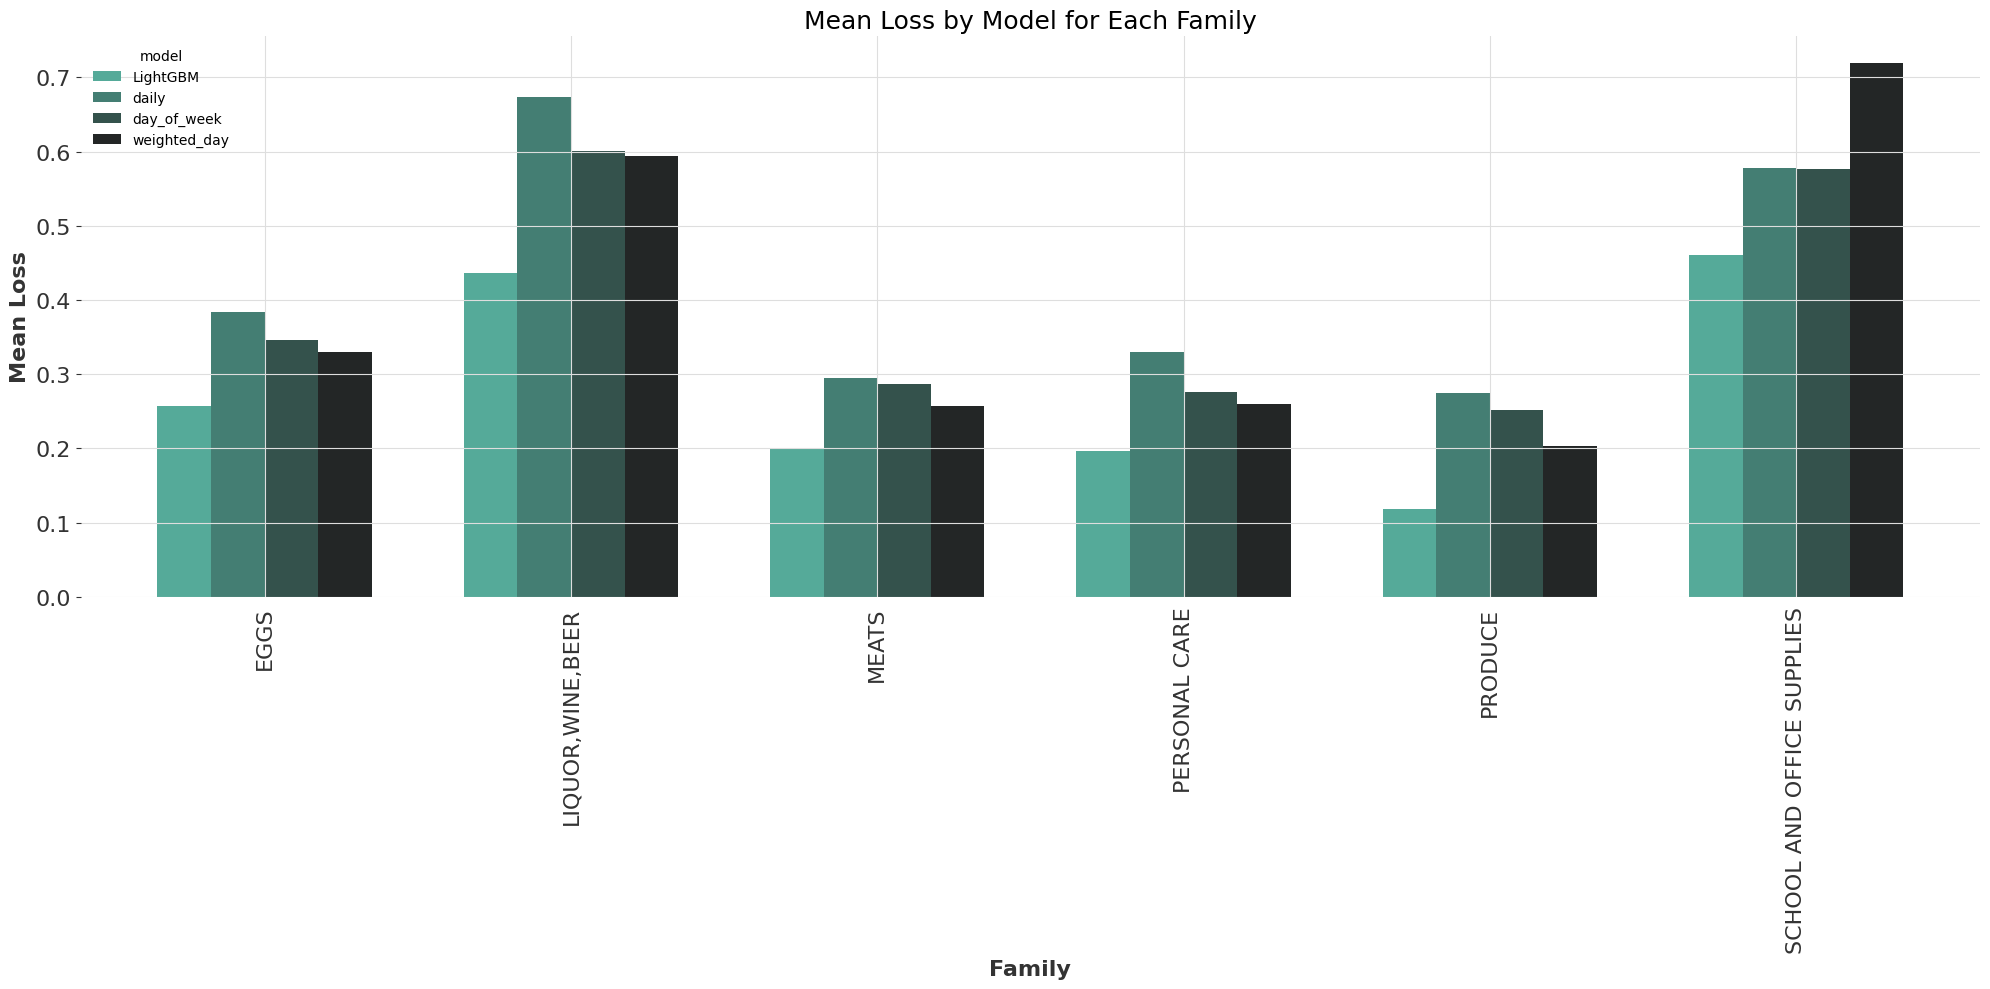

In [21]:
advanced_predictor.make_overall_family_loss_plot(
    families=families_for_lightgbm, test_loss=True
)

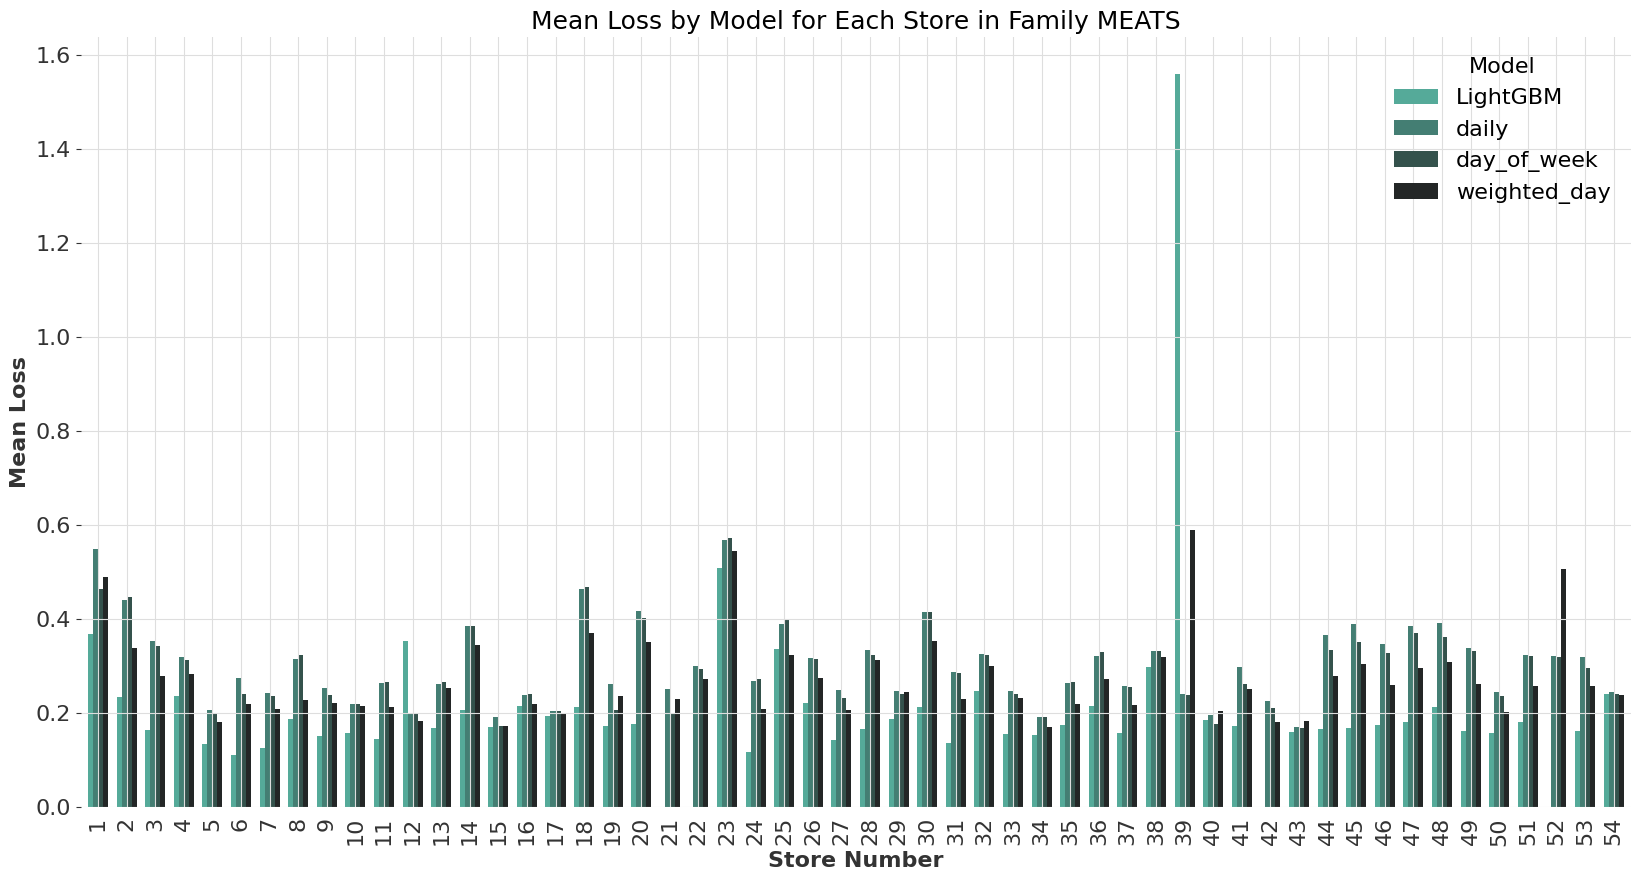

<Figure size 640x480 with 0 Axes>

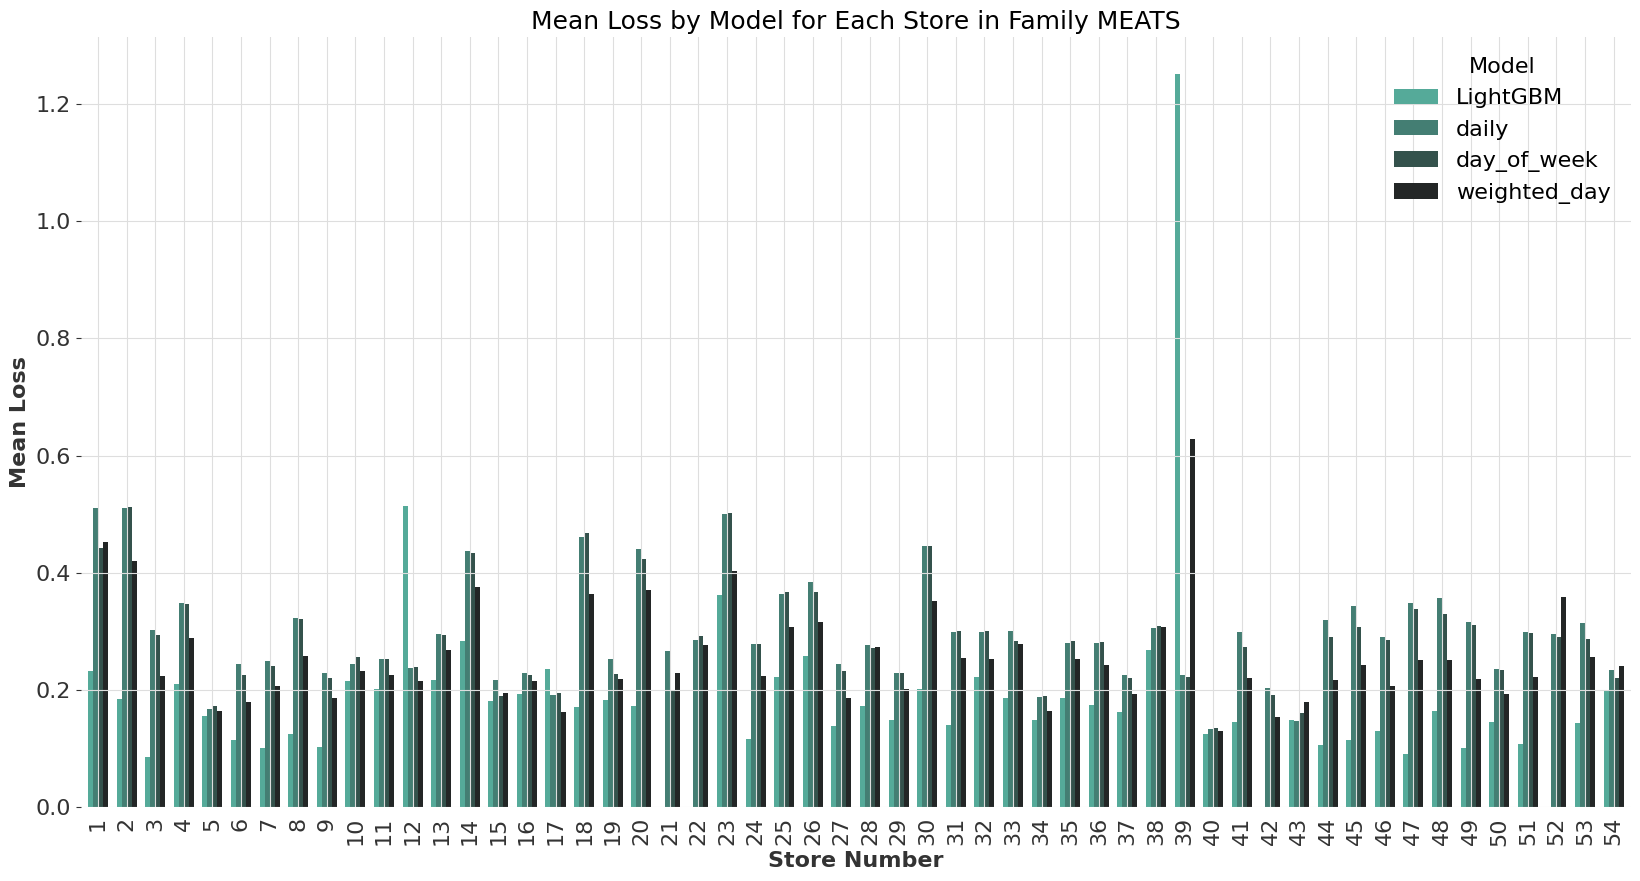

<Figure size 640x480 with 0 Axes>

In [32]:
advanced_predictor.make_family_loss_plot(family="MEATS", test_loss=False)
advanced_predictor.make_family_loss_plot(family="MEATS", test_loss=True)

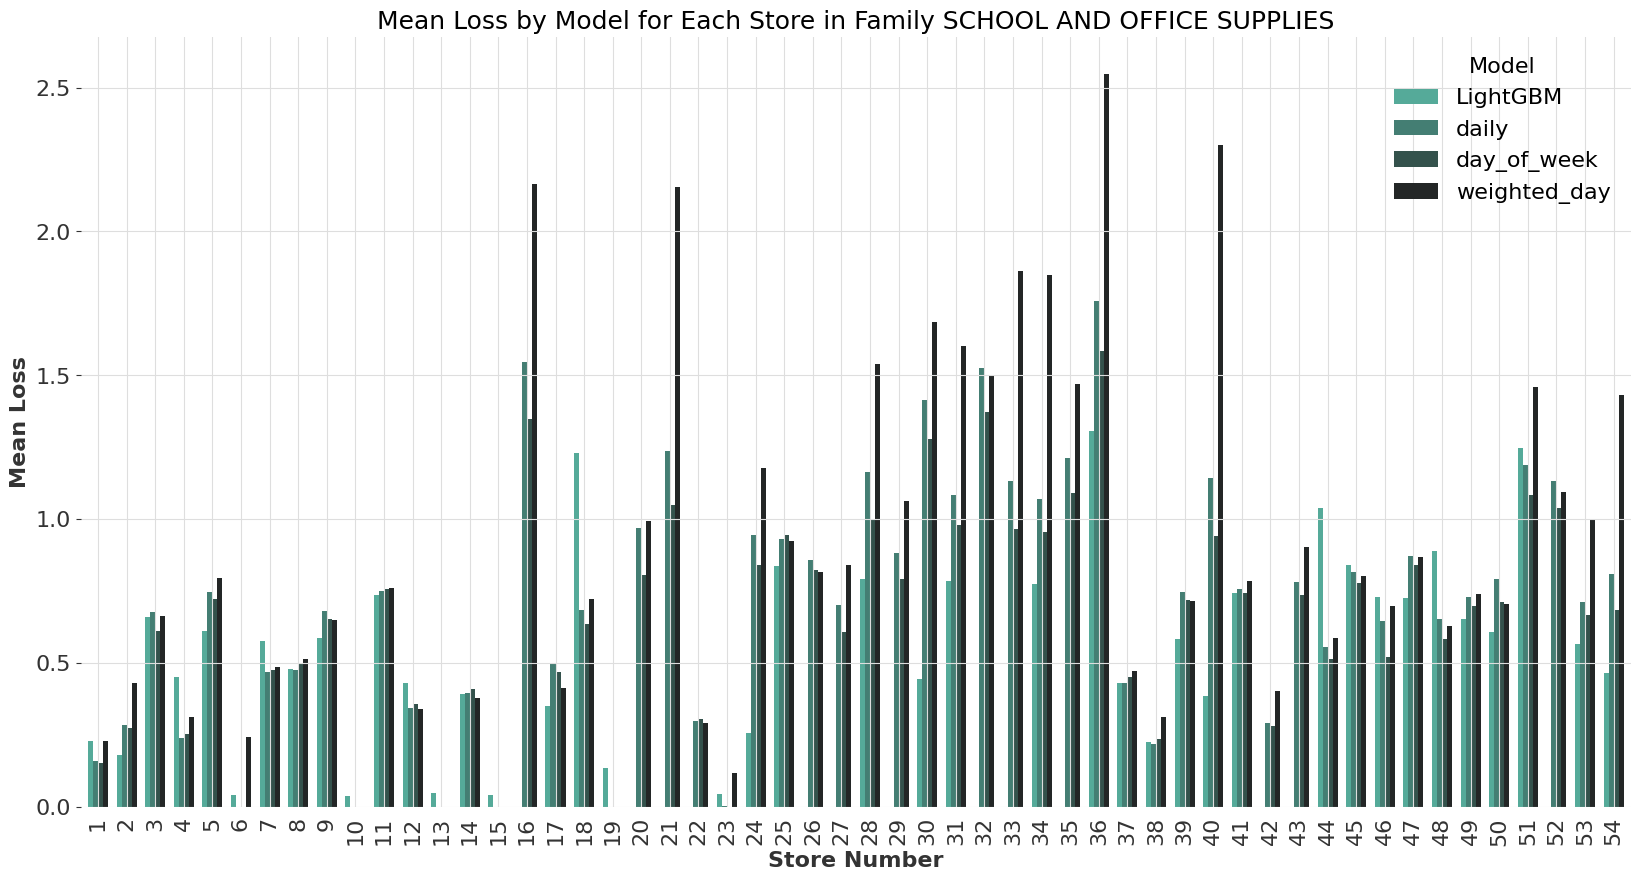

<Figure size 640x480 with 0 Axes>

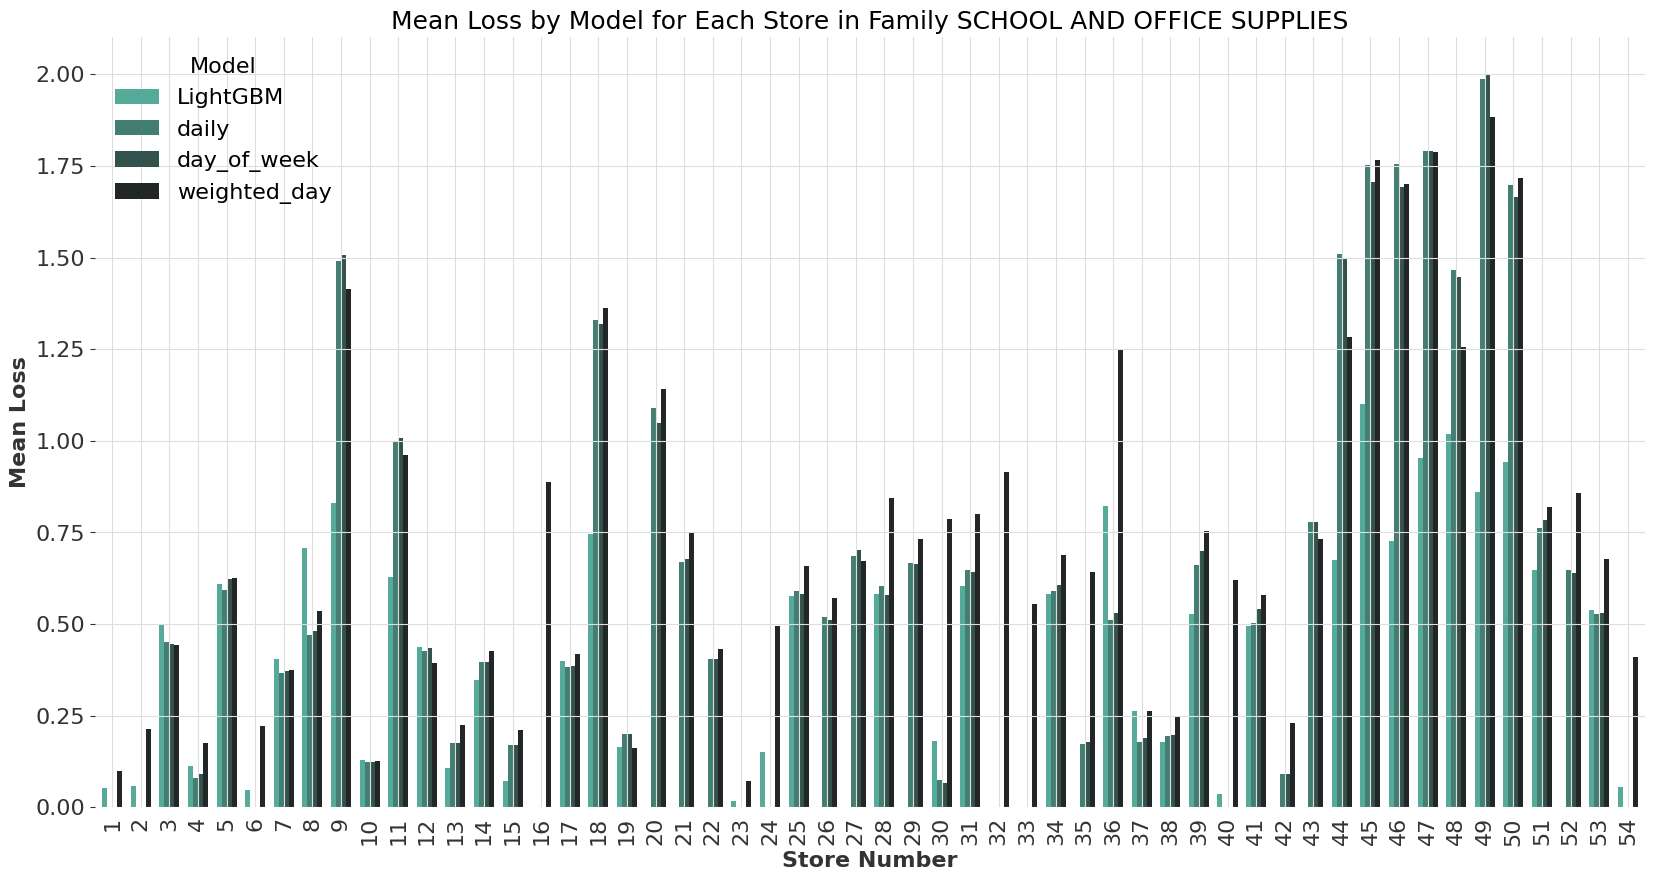

<Figure size 640x480 with 0 Axes>

In [33]:
advanced_predictor.make_family_loss_plot(
    family="SCHOOL AND OFFICE SUPPLIES", test_loss=False
)
advanced_predictor.make_family_loss_plot(
    family="SCHOOL AND OFFICE SUPPLIES", test_loss=True
)

## Get Optimal Prediction
### Each Store Strategy

In [27]:
optimal_prediction = advanced_predictor.get_optimal_prediction(strategy="each_store")
each_store_mean_loss = advanced_predictor.calc_mean_loss(
    optimal_prediction.index
).rename("each_store")

print(f"Mean Loss: {each_store_mean_loss.mean()}")

Mean Loss: 0.3553323300458746


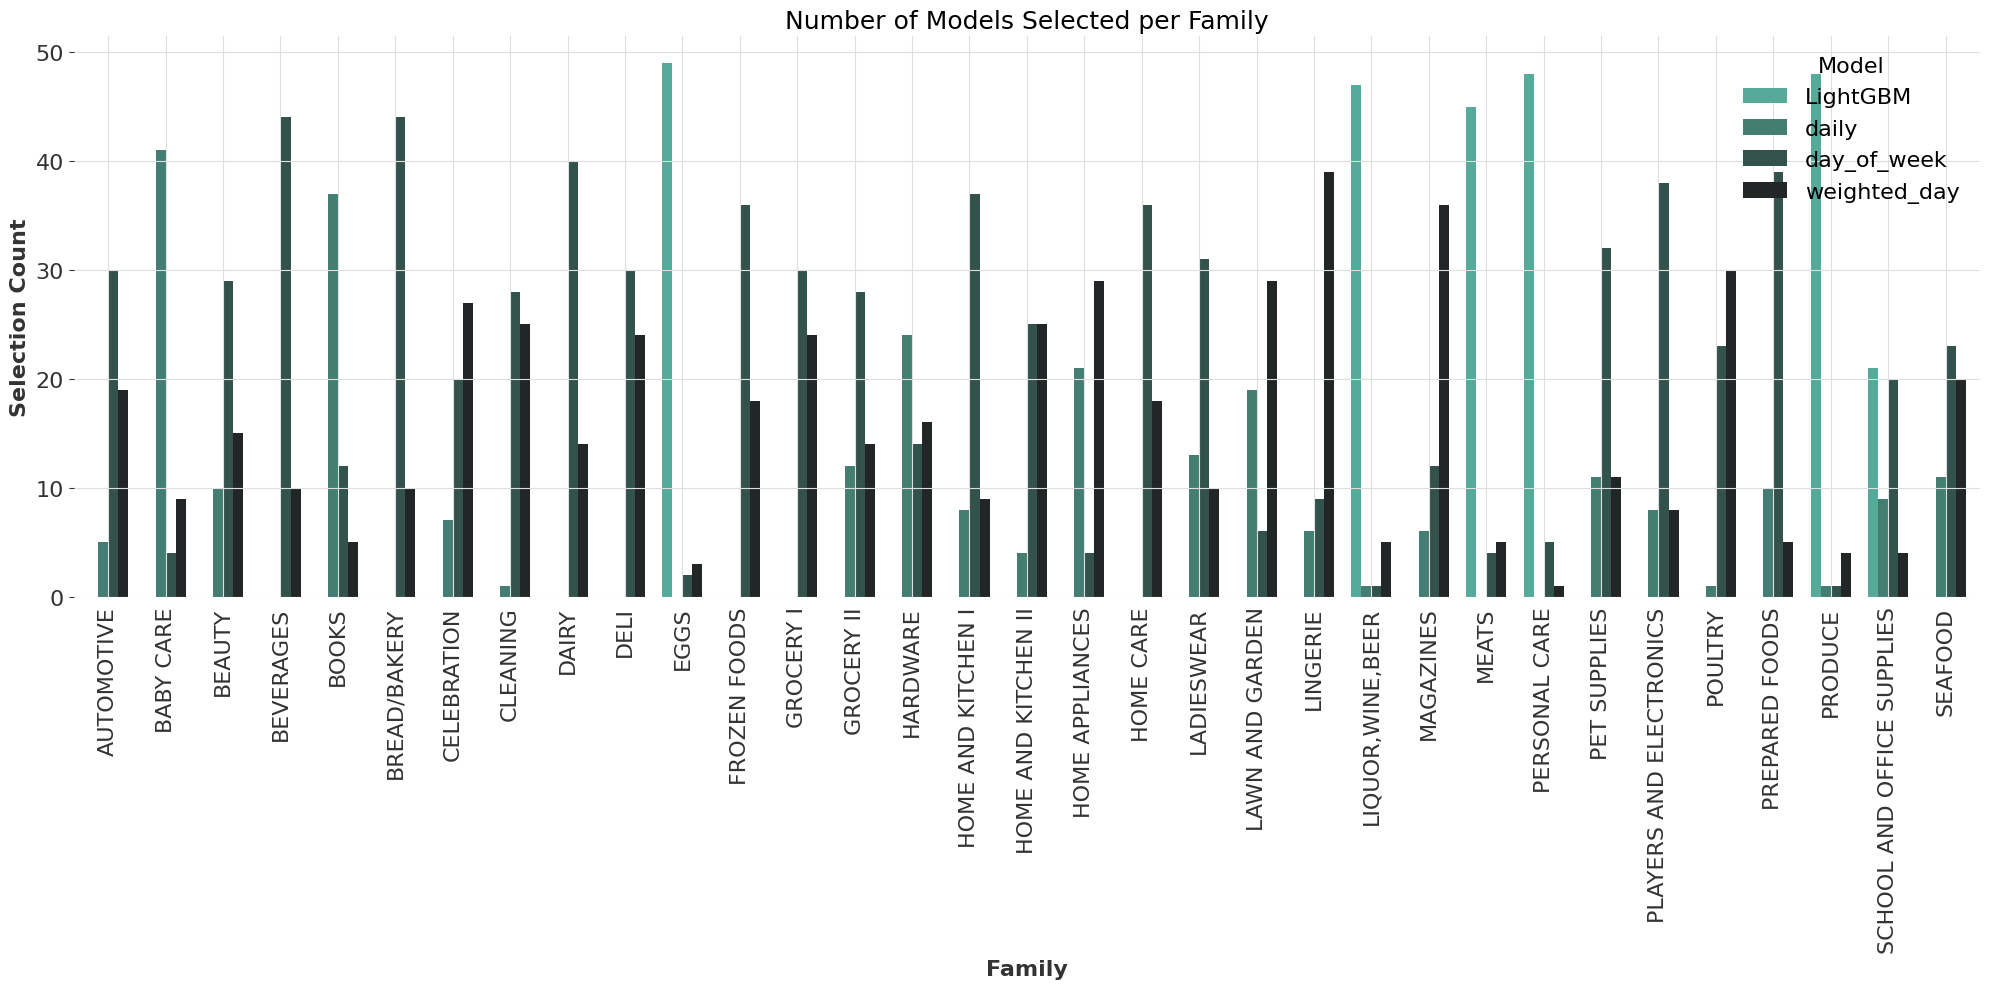

In [28]:
optimal_indices = advanced_predictor.get_optimal_model_ids(strategy="each_store")
advanced_predictor.make_model_selection_plot(optimal_indices)

### Mean Family Strategy

In [29]:
optimal_prediction = advanced_predictor.get_optimal_prediction(strategy="mean_family")
family_mean_loss = advanced_predictor.calc_mean_loss(optimal_prediction.index).rename(
    "mean_family"
)

print(f"Mean Loss: {family_mean_loss.mean()}")

Mean Loss: 0.35599079960269436


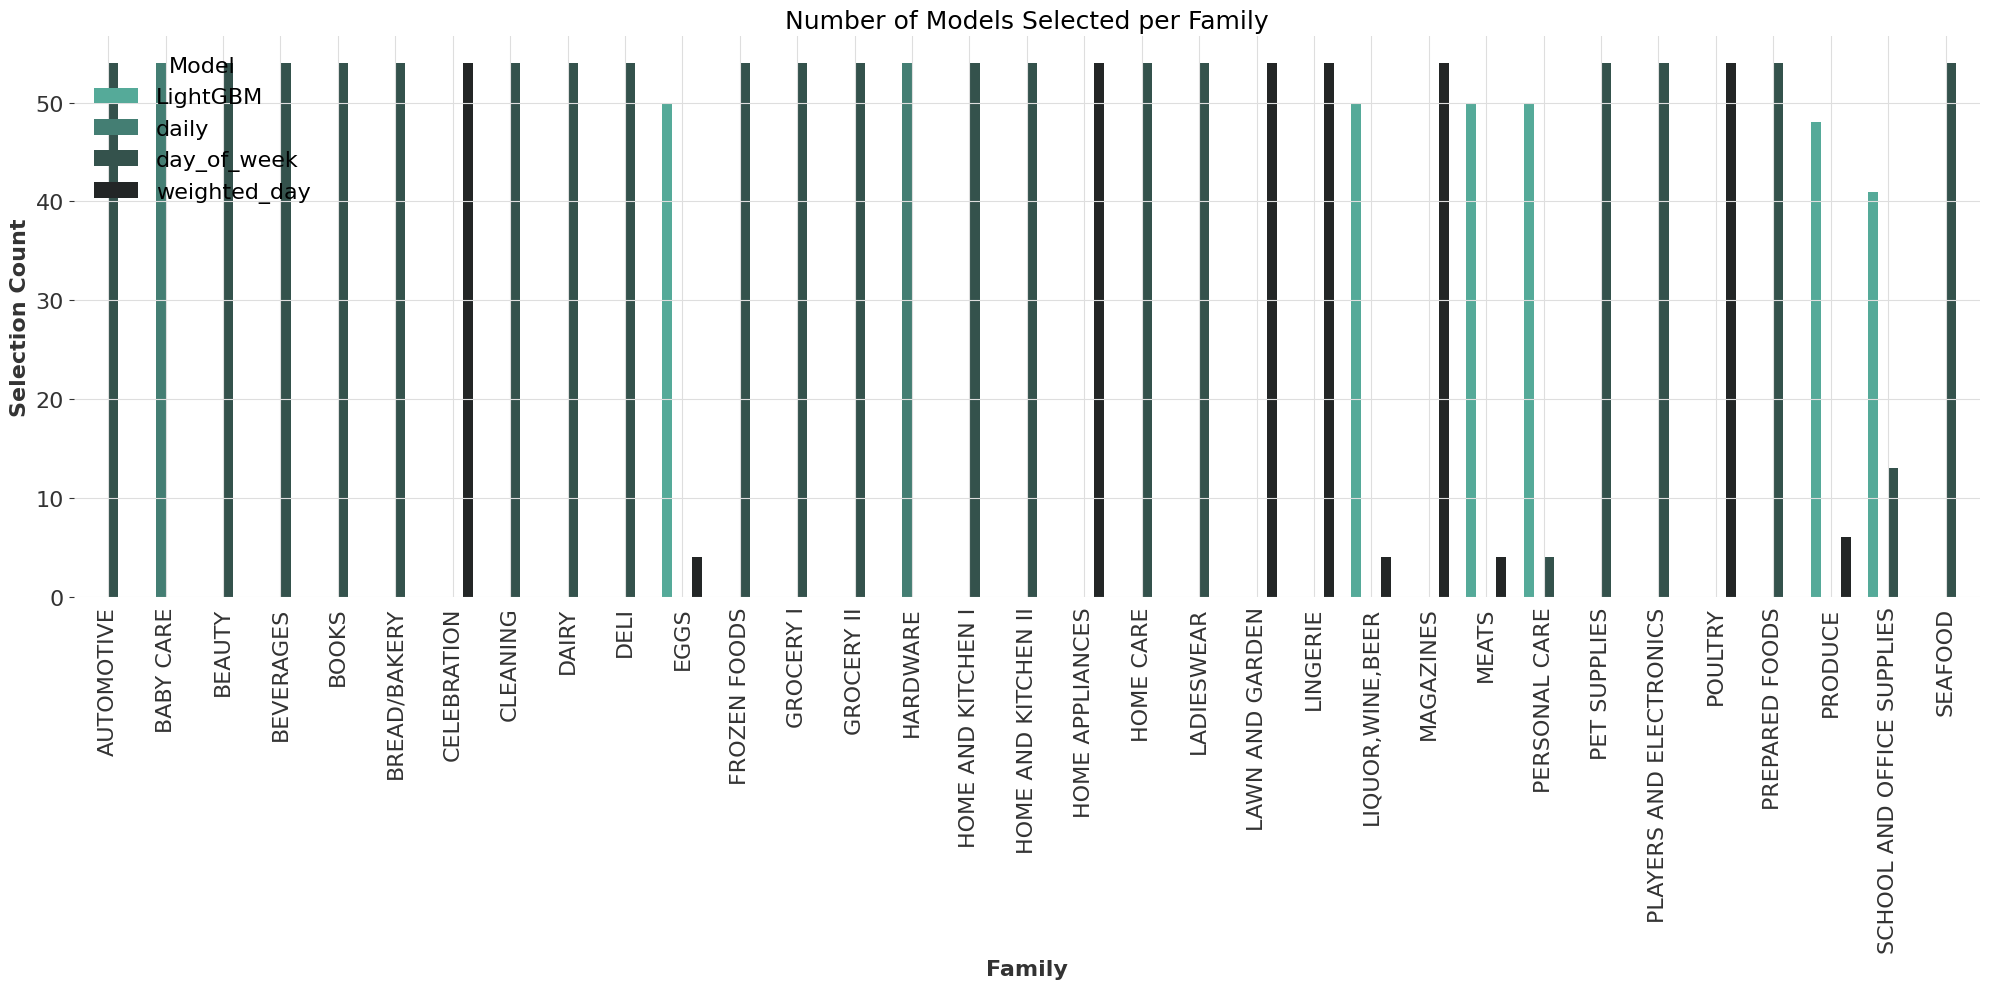

In [30]:
optimal_indices = advanced_predictor.get_optimal_model_ids(strategy="mean_family")
advanced_predictor.make_model_selection_plot(optimal_indices)

### Compare Strategies

In [31]:
losses_df = pd.concat([each_store_mean_loss, family_mean_loss], axis=1)
losses_df["diff"] = losses_df["each_store"] - losses_df["mean_family"]
losses_df

,each_store,mean_family,diff
family,,,
AUTOMOTIVE,0.516469,0.513222,0.003246
BABY CARE,0.210595,0.207980,0.002616
BEAUTY,0.518751,0.515993,0.002757
BEVERAGES,0.212935,0.214598,-0.001663
BOOKS,0.055820,0.056204,-0.000383
BREAD/BAKERY,0.189696,0.192065,-0.002369
CELEBRATION,0.566666,0.564472,0.002194
CLEANING,0.283243,0.300379,-0.017136
DAIRY,0.182769,0.185780,-0.003011


### Combined Strategy

In [15]:
optimal_prediction = advanced_predictor.get_optimal_prediction(strategy="combined")
family_mean_loss = advanced_predictor.calc_mean_loss(optimal_prediction.index)

print(f"Mean Loss: {family_mean_loss.mean()}")

Mean Loss: 0.35266558700251005


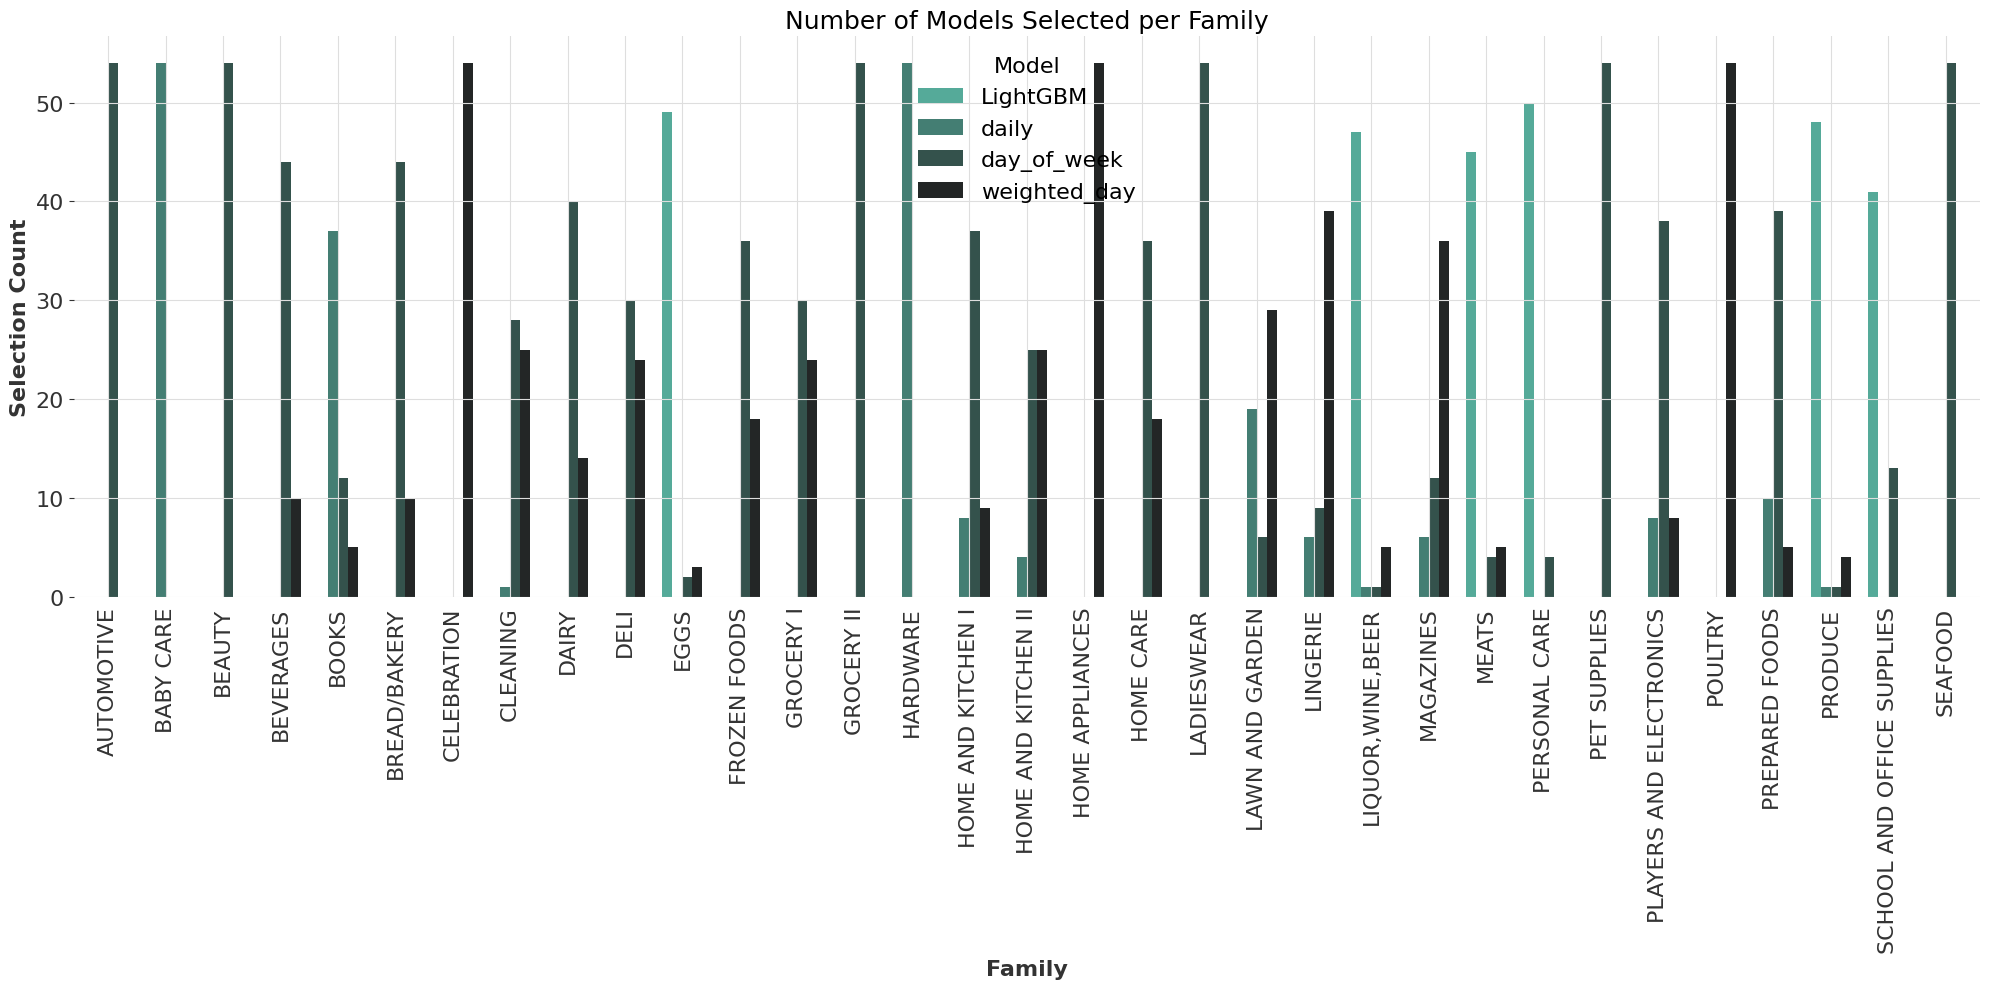

In [19]:
optimal_indices = advanced_predictor.get_optimal_model_ids(strategy="combined")
advanced_predictor.make_model_selection_plot(optimal_indices)